#  PnP-SGS using DDPM



# Download files:

In [1]:
!git clone https://github.com/DPS2022/diffusion-posterior-sampling.git
!cp -r diffusion-posterior-sampling/guided_diffusion guided_diffusion
!wget -nc -O ffhq256-1k-validation.zip 'https://www.dropbox.com/scl/fi/pppstbdsf0em6o0qscruc/ffhq256-1k-validation.zip?rlkey=xl7nwv2nxb6yvsirr3wad77hm'
!unzip -nq ffhq256-1k-validation.zip
!wget -nc -O ffhq_10m.pt 'https://www.dropbox.com/scl/fi/pq72vxzxcbygieq5z4gvf/ffhq_10m.pt?rlkey=5sxdj6r4o9f7b7bbp5fxg2f5r'

fatal: destination path 'diffusion-posterior-sampling' already exists and is not an empty directory.
File 'ffhq256-1k-validation.zip' already there; not retrieving.
File 'ffhq_10m.pt' already there; not retrieving.


In [2]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
from scipy.sparse.linalg import splu
from PIL import Image
from tqdm import tqdm
from guided_diffusion.unet import create_model

from tqdm.notebook import tqdm, trange

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print("Device:", device)

import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")


Device: cuda:0


# Display functions
We will work with PyTorch images with color values in $[-1,1]$ and the usual additional batch dimension.
Images will have size 1x3x256x256 in PyTorch.

Image 00445


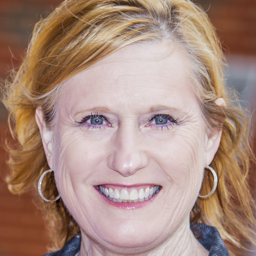

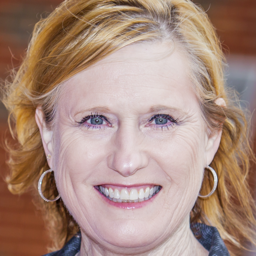

In [3]:
def pilimg_to_tensor(pil_img):
  t = torchvision.transforms.ToTensor()(pil_img)
  t = 2*t-1 # [0,1]->[-1,1]
  t = t.unsqueeze(0)
  t = t.to(device)
  return(t)

def display_as_pilimg(t):
  t = 0.5+0.5*t.to('cpu')
  t = t.squeeze()
  t = t.clamp(0.,1.)
  pil_img = torchvision.transforms.ToPILImage()(t)
  display(pil_img)
  return(pil_img)

idx = np.random.randint(1000)
print('Image', str(idx).zfill(5))
img_pil = Image.open('ffhq256-1k-validation/'+str(idx).zfill(5)+'.png')
display(img_pil)
display_as_pilimg(pilimg_to_tensor(img_pil));


# Load DDPM Unet

In [4]:
# Load model
model_config = {'image_size': 256,
                'num_channels': 128,
                'num_res_blocks': 1,
                'channel_mult': '',
                'learn_sigma': True,
                'class_cond': False,
                'use_checkpoint': False,
                'attention_resolutions': 16,
                'num_heads': 4,
                'num_head_channels': 64,
                'num_heads_upsample': -1,
                'use_scale_shift_norm': True,
                'dropout': 0.0,
                'resblock_updown': True,
                'use_fp16': False,
                'use_new_attention_order': False,
                'model_path': 'ffhq_10m.pt'}
model = create_model(**model_config)
model = model.to(device)
# use in eval mode:
model.eval();


In [5]:
class DDPM:
  def __init__(self, model=model):
    self.num_diffusion_timesteps = 1000
    self.reversed_time_steps = np.arange(self.num_diffusion_timesteps)[::-1]
    beta_start = 0.0001
    beta_end = 0.02
    self.betas = np.linspace(beta_start, beta_end, self.num_diffusion_timesteps,
                              dtype=np.float64)
    self.alphas = 1.0 - self.betas
    self.alphas_cumprod = np.cumprod(self.alphas, axis=0)
    self.alphas_cumprod_prev = np.append(1.0, self.alphas_cumprod[:-1])
    self.sigma = np.sqrt(1 - self.alphas_cumprod_prev )
    self.model = model
    self.imgshape = (1,3,256,256)


  def get_eps_from_model(self, x, t):
    model_output = self.model(x, torch.tensor(t, device=device).unsqueeze(0))
    model_output = model_output[:,:3,:,:]
    return(model_output)

  def predict_xstart_from_eps(self, x, eps, t):
    x_start = (
        np.sqrt(1.0 / self.alphas_cumprod[t])* x
        - np.sqrt(1.0 / self.alphas_cumprod[t] - 1) * eps
    )
    x_start = x_start.clamp(-1.,1.)
    return(x_start)

  def sampling_spliting_z(self, t_start, u_0, x_true, y, iteration, show_steps):
        with torch.no_grad():  # mode eval
            xt = u_0 
            xhat = torch.randn(self.imgshape, device=device)
            # t_start = min(t_start, 100)
            if iteration < 20 : 
                t_end = self.num_diffusion_timesteps - (t_start //2)
            else : 
                t_end = self.num_diffusion_timesteps

            diff_iter = self.reversed_time_steps[self.num_diffusion_timesteps - t_start:t_end]

            for i, t in enumerate(diff_iter):
                if t > 1:
                    z = torch.randn(self.imgshape, device=device)
                else:
                    z = torch.zeros(self.imgshape, device=device)

                alpha_t = self.alphas[t]
                alpha_bar_t = self.alphas_cumprod[t]
                sigma_t = np.sqrt(((1 - self.alphas_cumprod[t - 1]) / (1 - self.alphas_cumprod[t])) * self.betas[t])
                eps = self.get_eps_from_model(xt, t)

                xt = (1 / np.sqrt(alpha_t)) * (xt -  ((1 - alpha_t) / np.sqrt(1 - alpha_bar_t)) * eps ) + sigma_t * z
                xhat = self.predict_xstart_from_eps(xt, eps, t)

                
            if show_steps :
                    pilimg = display_as_pilimg(torch.cat((y, x_true, xt, xhat), dim=3))

        return xt
    
  def posterior_sampling(self, linear_operator, y, x_true=None, show_steps=True, vis_y=None):

    # visualization image for the observation y:
    if vis_y==None:
      vis_y = y

    # initialize xt for t=T
    x = torch.randn(self.imgshape,device=device)
    x.requires_grad = True


    for t in tqdm(self.reversed_time_steps[1:]):
      alpha_t = self.alphas[t]
      alpha_bar_t = self.alphas_cumprod[t]
      alpha_bar_tm1 = self.alphas_cumprod_prev[t]

      beta_t = self.betas[t]
      sigma_t = np.sqrt(beta_t)

      z = torch.randn(self.imgshape, device=device)

      xhat = self.predict_xstart_from_eps(x, self.get_eps_from_model(x,t), t)

      x_prime = np.sqrt(alpha_t) * (1-alpha_bar_tm1) / (1-alpha_bar_t) * x
      x_prime += np.sqrt(alpha_bar_tm1)*beta_t / (1-alpha_bar_t)*xhat
      x_prime += sigma_t*z

      df_term = torch.sum((y-linear_operator(xhat))**2)
      grad = torch.autograd.grad(df_term, x)[0]
      zeta = 1 / torch.sqrt(df_term)

      x = x_prime - zeta * grad

      if show_steps and (t)%100==0:
        print('Iteration :', t)
        pilimg = display_as_pilimg(torch.cat(( y, x_true, x, xhat), dim=3))

    return(x)

ddpm = DDPM()


## Generate Inpainting mask (operator H)

In [6]:
def create_binary_matrix(N, M):
    """
    Create a binary matrix representing a subsampling pattern for image inpainting.

    Parameters:
        N (int): Total number of pixels in the original, full-resolution image.
        M (int): Number of observed or known pixel values in the subsampled image.

    Returns:
        torch.Tensor: Binary matrix representing the subsampling pattern.
    """
    # Initialize the mask as a flattened vector of zeros
    mask = torch.zeros(N, dtype=torch.float32)
    
    # Randomly choose M indices to be observed (set to 1)
    observed_indices = torch.randperm(N)[:M]
    mask[observed_indices] = 1
    
    # Reshape the mask to a 2D image if necessary
    height = width = int(np.sqrt(N))  
    mask = mask.reshape(height, width)
    
    mask = mask.repeat(1, 3, 1, 1)

    return mask

N = 256 * 256  # Total number of pixels for a 256x256 image
M = 128*128  # Number of observed pixels for the subsampled image

# Create the binary matrix H representing the irregular subsampling pattern
mask = create_binary_matrix(N, M)

print("Shape of binary matrix H:", mask.size())


Shape of binary matrix H: torch.Size([1, 3, 256, 256])


cuda:0
original image 00012.png


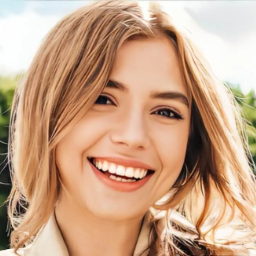

Inpainting image


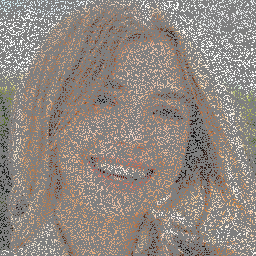

In [7]:
def linear_operator(x):
  x = x * mask.to(device)
  return(x)

idx = 12
x_true_pil = Image.open('/kaggle/input/image-dataset/index-main-after (1).png')
x_true = pilimg_to_tensor(x_true_pil)[:,:3,:,:]
print(x_true.device)
print("original image", str(idx).zfill(5)+'.png')
display_as_pilimg(x_true)

y = linear_operator(x_true.clone())
print("Inpainting image")
display_as_pilimg(y);


# Get the operator H from mask 

In [8]:
def sum_chunk(A, B):
    A = torch.tensor(A).cpu().squeeze().numpy()
    B = torch.tensor(B).cpu().squeeze().numpy()
    sum_result = np.zeros_like(A)
    chunk_size = 10000  
    size = A.size

    # Perform addition in chunks
    for i in range(0, size, chunk_size):
        chunk_A = A[i:i+chunk_size]
        chunk_B = B[i:i+chunk_size]
        sum_result[i:i+chunk_size] = chunk_A + chunk_B
    
    return torch.tensor(sum_result).to(device)

def sparse_cholesky(A):
    n = A.shape[0]
    LU = splu(A.tocsc(), diag_pivot_thresh=0)
    if (LU.perm_r == np.arange(n)).all() and (LU.U.diagonal() > 0).all():
        return LU.L @ sp.diags(LU.U.diagonal()**0.5)
    else:
        raise ValueError('The matrix is not positive definite')

def sample_from_sparse_gaussian(mu, cov_matrix):
    dim = len(mu)
    z = np.random.normal(size=(dim,))
    L = sparse_cholesky(cov_matrix)
    derive = L.dot(z)
    x = mu + derive
    return torch.tensor(x).to(device)

def sample_x_given_z_y(z, p2, y_flat, sigma2, HtH, eye_sparse):
    z_flat = z.flatten()
    cov = p2 * (eye_sparse - p2 * HtH / (p2 + sigma2))
    A = y_flat / sigma2 
    B = z_flat / p2
    summ = sum_chunk(A, B).cpu()
    moy = cov.dot(summ)
  
    return sample_from_sparse_gaussian(moy, cov).view(z.shape).to(device)

# Generate the operator H

In [9]:
# Get indices of non-zero elements from the mask matrix
nonzero_indices = torch.nonzero(mask.flatten(), as_tuple=False)[:, 0].to(device)

# Define the number of measurements 
M = len(nonzero_indices)
nonzero_indices = torch.stack([nonzero_indices, torch.arange(0, M, device=device)]).cpu()

# Create a sparse tensor from the non-zero indices
values = np.ones(M)  # All elements are ones for binary matrix
H = sp.coo_matrix((values, (nonzero_indices[0], nonzero_indices[1])), shape=(len(mask.flatten()), M)).tocsc()

# Generate H.Ht and Identity matrix

In [10]:
HtH = (H).dot(H.T)
eye_sparse = sp.eye(HtH.shape[0])

# Find t after noise_estimation

In [11]:
def inverse_variance_function(noise_level):
    closest_t_index = np.argmin(np.abs( (1-ddpm.alphas_cumprod) - noise_level**2))
    return closest_t_index

In [12]:
import torch
from skimage.restoration import estimate_sigma
from tqdm import tqdm

def PNP_SGS(ro, MCMC_steps, y, Burn_in_steps, show_only_last=False):
    N = 256  
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    y = torch.tensor(y).to(device)  # Observed measurements
    z = torch.randn(y.shape).to(device)  # initialize z
    ro = ro

    noise_level = estimate_sigma(y[0].cpu().numpy(), channel_axis=0, average_sigmas=True)
    x_flatten = x_true.flatten()  
    y_flatten = x_flatten + sigma_noise * torch.randn_like(x_flatten)
    y_flatten = HtH.dot(y_flatten.cpu().numpy())

    N_burn_in = Burn_in_steps
    x_samples = []
    time = []

    show = not show_only_last

    for n in tqdm(range(MCMC_steps)):  # MCMC
        if n == MCMC_steps - 1:
            show = True

        if show:
            print(f"---------------- Iteration {n} ------------")
        
        # Step 1: sample from x given z and y  : equation 6
        x = sample_x_given_z_y(z, ro**2, y_flatten, sigma_noise**2, HtH, eye_sparse).float()

        # Step 2: estimating noise level
        noise_level = estimate_sigma(x[0].cpu().numpy(), channel_axis=0, average_sigmas=True)
        
        # Step 3: find t
        t_star = inverse_variance_function(noise_level)
        time.append(t_star)

        if show:
            print(f"noise level estimated = {noise_level}")
            print(f"number of noising steps = {t_star}")
        
        # Step 3 : Sample z via reverse diffusion : equation 7
        z = ddpm.sampling_spliting_z(t_star, x, x_true, y, n, show_steps=show)

        if n > N_burn_in:
            x_samples.append(z)

    return x_samples, time


In [ ]:
x_samples, time = PNP_SGS(0.1,110,y,20, show_only_last=True) 

  0%|          | 0/110 [00:00<?, ?it/s]

In [ ]:
x_samples, time = PNP_SGS(0.1,100,y,20, show_only_last=True) 

In [ ]:
x_samples, time = PNP_SGS(0.1,100,y,20, show_only_last=False) 

# MMSE of the last 20 images

In [ ]:
im = display_as_pilimg(sum(x_samples[-20:])/ len(x_samples[-20:]))

# Evolution of t along the PnP-SGS iterations (T = 1000)

In [ ]:
plt.plot(time)

# PNP-SGS for ro = 0.01

In [ ]:
x_samples, time = PNP_SGS(0.01,150,y,20, show_only_last=True)  

# PNP-SGS for ro = 0.05

In [ ]:
x_samples, time = PNP_SGS(0.05,100,y,20, show_only_last=True)  

# PNP-SGS for ro = 1.2

In [ ]:
x_samples, time = PNP_SGS(1.2,100,y,20, show_only_last=True)  

# PNP-SGS for ro = 1.6

In [ ]:
x_samples, time = PNP_SGS(1.6,100,y,20, show_only_last=True)  

# PNP-SGS for ro = 2

In [ ]:
x_samples, time = PNP_SGS(2,100,y,20, show_only_last=True) 

# DIFFUSION POSTERIOR SAMPLING


> Initialize $x_T$ as for unconditional sampling.
>
> For $t=T$ to $1$:
>  1. Predict $\hat{\bx_0}(\bx_t,t)$.
>  2. Compute the squared $\ell^2$ error $\|A\hat{\bx_0}(\bx_t,t) - \mathbf{y} \|^2$.
>  3. Define
>  $$ \bx_{t-1} = \mu_\theta(\bx_{t}, t) + \sqrt{\beta_t} \bz - \zeta_t \nabla_{\bx_t} \|A\hat{\bx_0}(\bx_t,t) - \mathbf{y} \|^2. $$
> where the scaling factor $\zeta_t$ has been experimentally fixed as $\|A\hat{\bx_0}(\bx_t,t) - \mathbf{y}\|^{-1}$.

In [ ]:
x0 = ddpm.posterior_sampling(linear_operator, y, x_true=x_true, show_steps=True)

#